In [1]:
%load_ext autoreload
%autoreload 1
%aimport helpers, loaders, plotters

In [2]:
# This helps with joblib "No space left on device" errors
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [3]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, balanced_accuracy, load_best_search, load_best_learning, save_learning_curve, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

### Load Data

In [4]:
dataset = 'MNIST'
learner_type = 'ANN'
loader_func = load_mnist

In [5]:
df = loader_func(preprocess=True)

Target column encoded with the following classes [ 4.  9.]
Dataset shape (13782, 785)
Value composition:
1    0.504861
0    0.495139
Name: target, dtype: float64


/home/jovyan/loaders.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_df['target'] = le.fit_transform(filtered_df['target'])


### Split data into training and testing

In [6]:
from sklearn.model_selection import train_test_split

X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [7]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Neural Nets

In [8]:
# Build a KerasClassifier for use with scikit-learn
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier


n_features = X_train.shape[1]


def build_keras_clf(hidden_layer_sizes=(10,10), learning_rate_init=0.01, momentum=0.8):
    """This function builds a Keras model for use with scikit's GridSearch"""
    if not isinstance(hidden_layer_sizes, tuple):
        hidden_layer_sizes = (hidden_layer_sizes,)
    
    model = Sequential()
    
    model.add(Dense(units=n_features, input_shape=(n_features,), activation='relu'))
    
    for layer_size in hidden_layer_sizes:
        assert layer_size > 0
        model.add(Dense(units=layer_size, activation='relu'))
    
    # Add output layer
    model.add(Dense(units=1, activation='sigmoid'))
        
    sgd = SGD(lr=learning_rate_init, momentum=momentum, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=["accuracy"])
    
    return model

clf = KerasClassifier(build_fn=build_keras_clf, verbose=0)

Using TensorFlow backend.


### GridSearch for model complexity curves

In [9]:
layer_sizes = [
    (10,10),
    (50,50),
    (100,100),
]

param_grid = {
    'hidden_layer_sizes': layer_sizes,
    'learning_rate_init': [0.01, .1, .2],
    'momentum': [0.7, 0.8, 0.9],
    'epochs': [10, 100, 200]
}

In [10]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=1,
)

In [11]:
grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] epochs=1, hidden_layer_sizes=(10, 10) ...........................
[CV] epochs=1, hidden_layer_sizes=(10, 10) ...........................
[CV] epochs=1, hidden_layer_sizes=(10, 10) ...........................
[CV] epochs=1, hidden_layer_sizes=(10, 10) ...........................
[CV]  epochs=1, hidden_layer_sizes=(10, 10), score=0.9469320066334992, total=   5.2s
[CV] epochs=1, hidden_layer_sizes=(100, 100) .........................
[CV]  epochs=1, hidden_layer_sizes=(10, 10), score=0.9535655058043118, total=   5.8s
[CV] epochs=1, hidden_layer_sizes=(100, 100) .........................
[CV]  epochs=1, hidden_layer_sizes=(10, 10), score=0.9481757877280266, total=   6.1s
[CV]  epochs=1, hidden_layer_sizes=(10, 10), score=0.9547905433430112, total=   6.2s
[CV] epochs=1, hidden_layer_sizes=(100, 100) .........................
[CV] epochs=1, hidden_layer_sizes=(100, 100) .........................
[CV]  epochs=1, hidden_layer_siz

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.1s


[CV]  epochs=1, hidden_layer_sizes=(100, 100), score=0.9444444444444444, total=   5.7s
[CV] epochs=10, hidden_layer_sizes=(10, 10) ..........................
[CV]  epochs=1, hidden_layer_sizes=(100, 100), score=0.9548092868988391, total=   6.2s
[CV] epochs=10, hidden_layer_sizes=(10, 10) ..........................
[CV]  epochs=1, hidden_layer_sizes=(100, 100), score=0.9639153878058897, total=   6.5s
[CV] epochs=10, hidden_layer_sizes=(10, 10) ..........................
[CV]  epochs=10, hidden_layer_sizes=(10, 10), score=0.9792703150912107, total=  46.0s
[CV] epochs=10, hidden_layer_sizes=(100, 100) ........................
[CV]  epochs=10, hidden_layer_sizes=(10, 10), score=0.9780265339966833, total=  46.0s
[CV] epochs=10, hidden_layer_sizes=(100, 100) ........................
[CV]  epochs=10, hidden_layer_sizes=(10, 10), score=0.978441127694859, total=  46.4s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min


[CV] epochs=10, hidden_layer_sizes=(100, 100) ........................
[CV]  epochs=10, hidden_layer_sizes=(10, 10), score=0.9838241393612609, total=  47.2s
[CV] epochs=10, hidden_layer_sizes=(100, 100) ........................
[CV]  epochs=10, hidden_layer_sizes=(100, 100), score=0.9763681592039801, total=  54.9s
[CV] epochs=100, hidden_layer_sizes=(10, 10) .........................
[CV]  epochs=10, hidden_layer_sizes=(100, 100), score=0.9817578772802653, total=  56.2s
[CV] epochs=100, hidden_layer_sizes=(10, 10) .........................
[CV]  epochs=10, hidden_layer_sizes=(100, 100), score=0.9871422646204894, total=  55.3s
[CV] epochs=100, hidden_layer_sizes=(10, 10) .........................
[CV]  epochs=10, hidden_layer_sizes=(100, 100), score=0.9767827529021559, total=  56.9s
[CV] epochs=100, hidden_layer_sizes=(10, 10) .........................
[CV]  epochs=100, hidden_layer_sizes=(10, 10), score=0.9854892205638475, total= 8.1min
[CV] epochs=100, hidden_layer_sizes=(100, 100) ..

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 10.1min


[CV]  epochs=100, hidden_layer_sizes=(10, 10), score=0.9879767827529021, total= 8.1min
[CV] epochs=100, hidden_layer_sizes=(100, 100) .......................
[CV]  epochs=100, hidden_layer_sizes=(10, 10), score=0.9871475953565506, total= 8.1min
[CV] epochs=100, hidden_layer_sizes=(100, 100) .......................
[CV]  epochs=100, hidden_layer_sizes=(10, 10), score=0.9921194525093322, total= 8.1min


[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed: 10.1min remaining:  2.0min


[CV] epochs=100, hidden_layer_sizes=(100, 100) .......................
[CV]  epochs=100, hidden_layer_sizes=(100, 100), score=0.9879767827529021, total= 9.2min
[CV]  epochs=100, hidden_layer_sizes=(100, 100), score=0.9846600331674958, total= 9.2min
[CV]  epochs=100, hidden_layer_sizes=(100, 100), score=0.9925342181667358, total= 9.2min
[CV]  epochs=100, hidden_layer_sizes=(100, 100), score=0.988391376451078, total= 9.2min


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 19.3min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fad17804780>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(10, 10), (100, 100)], 'epochs': [1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [12]:
save_search_result(grid_search, dataset, learner_type)

### Model Complexity Analysis

In [19]:
res = grid_search.cv_results_
# res = load_best_search(dataset, learner_type)
res_df = scikit_cv_result_to_df(res)
res_df.sort_values(by='rank_test_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  \
epochs hidden_layer_sizes                                                 
100    (100, 100)             550.075132      0.822170         0.465952   
       (10, 10)               486.131520      0.911275         0.576545   
10     (100, 100)              55.276097      0.870719         0.545207   
       (10, 10)                45.947840      0.487249         0.467092   
1      (100, 100)               5.520763      0.448443         0.420572   
       (10, 10)                 5.384624      0.425658         0.445067   

                           std_score_time  mean_test_score  std_test_score  \
epochs hidden_layer_sizes                                                    
100    (100, 100)                0.159300         0.988390        0.002795   
       (10, 10)                  0.094041         0.988183        0.002442   
10     (100, 100)                0.094793         0.980512        0.004376   
       (10, 10)                  0.071581         0.979890        0.002315   
1      (100, 100)                0.096855         0.954908        0.006947   
       (10, 10)                  0.040614         0.950866        0.003369   

                           rank_test_score  mean_train_score  std_train_score  
epochs hidden_layer_sizes                                                      
100    (100, 100)                        1          0.999551         0.000180  
       (10, 10)                          2          0.999551         0.000115  
10     (100, 100)                        3          0.993089         0.000684  
       (10, 10)                          4          0.992675         0.000561  
1      (100, 100)                        5          0.956636         0.006418  
       (10, 10)                          6          0.952075         0.001057

In [20]:
small_network = res_df.xs((10,10), level='hidden_layer_sizes')
large_network = res_df.xs((100,100), level='hidden_layer_sizes')

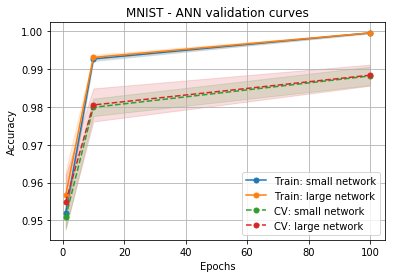

In [21]:
# Plot combined validation curve
plot_means_w_stds(
    means=(small_network['mean_train_score'], large_network['mean_train_score'], small_network['mean_test_score'], large_network['mean_test_score']),
    stds=(small_network['std_train_score'], large_network['std_train_score'], small_network['std_test_score'], large_network['std_test_score']),
    xrange=param_grid['epochs'],
    xlabel='Epochs',
    ylabel='Accuracy',
    series_labels=('Train: small network', 'Train: large network', 'CV: small network', 'CV: large network'),
    title='MNIST - ANN validation curves',
    legend_kwargs={'loc': 'best'}
)

### Timing Analysis

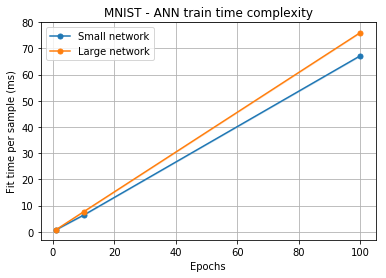

In [22]:
means = [small_network['mean_fit_time'], large_network['mean_fit_time']]
stds = [small_network['std_fit_time'], large_network['std_fit_time']]
labels = ['Small network', 'Large network']

# Calculate per-sample mean
n_samples = X_train_scaled.shape[0] * 3/4 # three-quarters of dataset was fit for 4-fold validation
# convert to milliseconds
means_per_samp = [mean / n_samples * 1000 for mean in means]
stds_per_samp = [std / n_samples * 1000 for std in stds]

plot_means_w_stds(
    means_per_samp,
    stds_per_samp,
    param_grid['epochs'],
    series_labels=labels,
    title='MNIST - ANN train time complexity',
    legend_kwargs={'loc': 'best'},
    ylabel='Fit time per sample (ms)',
    xlabel='Epochs',
    linestyles=['-']*2,
#     fig_kwargs={'figsize': (10,6)},
)

## Learning Curves for best learner

In [23]:
best_params = res['params'][np.argmax(res['mean_test_score'])]
clf = KerasClassifier(build_fn=build_keras_clf, verbose=0, **best_params)
clf.get_params()

{'epochs': 100,
 'hidden_layer_sizes': (100, 100),
 'build_fn': <function __main__.build_keras_clf(hidden_layer_sizes=(10, 10), learning_rate_init=0.01, momentum=0.8)>}

Epoch 1/100
723/723 [==============================] - 0s 463us/step - loss: 0.2434 - acc: 0.5754
Epoch 2/100
723/723 [==============================] - 0s 286us/step - loss: 0.2006 - acc: 0.8631
Epoch 3/100
723/723 [==============================] - 0s 287us/step - loss: 0.1440 - acc: 0.9322
Epoch 4/100
723/723 [==============================] - 0s 310us/step - loss: 0.0934 - acc: 0.9502
Epoch 5/100
723/723 [==============================] - 0s 338us/step - loss: 0.0654 - acc: 0.9585
Epoch 6/100
723/723 [==============================] - 0s 318us/step - loss: 0.0510 - acc: 0.9599
Epoch 7/100
723/723 [==============================] - 0s 331us/step - loss: 0.0419 - acc: 0.9627
Epoch 8/100
723/723 [==============================] - 0s 322us/step - loss: 0.0366 - acc: 0.9640
Epoch 9/100
723/723 [==============================] - 0s 336us/step - loss: 0.0326 - acc: 0.9696
Epoch 10/100
723/723 [==============================] - 0s 370us/step - loss: 0.0292 - acc: 0.9737
Epoch 11/100
723/72

723/723 [==============================] - 0s 302us/step - loss: 6.6100e-04 - acc: 1.0000
Epoch 84/100
723/723 [==============================] - 0s 324us/step - loss: 6.3906e-04 - acc: 1.0000
Epoch 85/100
723/723 [==============================] - 0s 327us/step - loss: 6.2409e-04 - acc: 1.0000
Epoch 86/100
723/723 [==============================] - 0s 333us/step - loss: 6.0942e-04 - acc: 1.0000
Epoch 87/100
723/723 [==============================] - 0s 294us/step - loss: 5.9775e-04 - acc: 1.0000
Epoch 88/100
723/723 [==============================] - 0s 302us/step - loss: 5.7805e-04 - acc: 1.0000
Epoch 89/100
723/723 [==============================] - 0s 305us/step - loss: 5.6510e-04 - acc: 1.0000
Epoch 90/100
723/723 [==============================] - 0s 286us/step - loss: 5.4992e-04 - acc: 1.0000
Epoch 91/100
723/723 [==============================] - 0s 295us/step - loss: 5.4087e-04 - acc: 1.0000
Epoch 92/100
723/723 [==============================] - 0s 310us/step - loss: 5.2567e-

1447/1447 [==============================] - 0s 278us/step - loss: 0.0012 - acc: 0.9993
Epoch 63/100
1447/1447 [==============================] - 0s 279us/step - loss: 0.0012 - acc: 0.9993
Epoch 64/100
1447/1447 [==============================] - 0s 271us/step - loss: 0.0011 - acc: 0.9993
Epoch 65/100
1447/1447 [==============================] - 0s 284us/step - loss: 0.0011 - acc: 0.9993
Epoch 66/100
1447/1447 [==============================] - 0s 280us/step - loss: 0.0011 - acc: 0.9993
Epoch 67/100
1447/1447 [==============================] - 0s 266us/step - loss: 0.0011 - acc: 0.9993
Epoch 68/100
1447/1447 [==============================] - 0s 278us/step - loss: 0.0011 - acc: 0.9993
Epoch 69/100
1447/1447 [==============================] - 0s 263us/step - loss: 0.0011 - acc: 0.9993
Epoch 70/100
1447/1447 [==============================] - 0s 263us/step - loss: 0.0011 - acc: 0.9993
Epoch 71/100
1447/1447 [==============================] - 0s 249us/step - loss: 0.0010 - acc: 0.9993
Epo

2170/2170 [==============================] - 1s 276us/step - loss: 0.0017 - acc: 0.9991
Epoch 42/100
2170/2170 [==============================] - 1s 269us/step - loss: 0.0016 - acc: 0.9991
Epoch 43/100
2170/2170 [==============================] - 1s 282us/step - loss: 0.0016 - acc: 0.9991
Epoch 44/100
2170/2170 [==============================] - 1s 288us/step - loss: 0.0016 - acc: 0.9991
Epoch 45/100
2170/2170 [==============================] - 1s 273us/step - loss: 0.0015 - acc: 0.9991
Epoch 46/100
2170/2170 [==============================] - 1s 277us/step - loss: 0.0015 - acc: 0.9991
Epoch 47/100
2170/2170 [==============================] - 1s 279us/step - loss: 0.0015 - acc: 0.9991
Epoch 48/100
2170/2170 [==============================] - 1s 274us/step - loss: 0.0014 - acc: 0.9991
Epoch 49/100
2170/2170 [==============================] - 1s 273us/step - loss: 0.0014 - acc: 0.9991
Epoch 50/100
2170/2170 [==============================] - 1s 278us/step - loss: 0.0014 - acc: 0.9991
Epo

2894/2894 [==============================] - 1s 297us/step - loss: 0.0064 - acc: 0.9952
Epoch 20/100
2894/2894 [==============================] - 1s 327us/step - loss: 0.0057 - acc: 0.9959
Epoch 21/100
2894/2894 [==============================] - 1s 318us/step - loss: 0.0050 - acc: 0.9969
Epoch 22/100
2894/2894 [==============================] - 1s 306us/step - loss: 0.0047 - acc: 0.9976
Epoch 23/100
2894/2894 [==============================] - 1s 306us/step - loss: 0.0044 - acc: 0.9972
Epoch 24/100
2894/2894 [==============================] - 1s 303us/step - loss: 0.0039 - acc: 0.9976
Epoch 25/100
2894/2894 [==============================] - 1s 300us/step - loss: 0.0036 - acc: 0.9983
Epoch 26/100
2894/2894 [==============================] - 1s 294us/step - loss: 0.0033 - acc: 0.9983
Epoch 27/100
2894/2894 [==============================] - 1s 309us/step - loss: 0.0031 - acc: 0.9983
Epoch 28/100
2894/2894 [==============================] - 1s 294us/step - loss: 0.0029 - acc: 0.9986
Epo

2894/2894 [==============================] - 1s 362us/step - loss: 8.0006e-04 - acc: 0.9993
Epoch 99/100
2894/2894 [==============================] - 1s 282us/step - loss: 7.9716e-04 - acc: 0.9993
Epoch 100/100
2894/2894 [==============================] - 0s 75us/step
Epoch 1/100
3617/3617 [==============================] - 1s 366us/step - loss: 0.1286 - acc: 0.8734
Epoch 2/100
3617/3617 [==============================] - 1s 308us/step - loss: 0.0413 - acc: 0.9563
Epoch 3/100
3617/3617 [==============================] - 1s 285us/step - loss: 0.0304 - acc: 0.9635
Epoch 4/100
3617/3617 [==============================] - 1s 277us/step - loss: 0.0287 - acc: 0.9663
Epoch 5/100
3617/3617 [==============================] - 1s 281us/step - loss: 0.0223 - acc: 0.9748
Epoch 6/100
3617/3617 [==============================] - 1s 276us/step - loss: 0.0198 - acc: 0.9795
Epoch 7/100
3617/3617 [==============================] - 1s 280us/step - loss: 0.0190 - acc: 0.9784
Epoch 8/100
3617/3617 [========

3617/3617 [==============================] - 1s 319us/step - loss: 4.0215e-04 - acc: 0.9997
Epoch 77/100
3617/3617 [==============================] - 1s 292us/step - loss: 3.9824e-04 - acc: 0.9997
Epoch 78/100
3617/3617 [==============================] - 1s 284us/step - loss: 3.9464e-04 - acc: 0.9997
Epoch 79/100
3617/3617 [==============================] - 1s 281us/step - loss: 3.9161e-04 - acc: 0.9997
Epoch 80/100
3617/3617 [==============================] - 1s 268us/step - loss: 3.8905e-04 - acc: 0.9997
Epoch 81/100
3617/3617 [==============================] - 1s 283us/step - loss: 3.8693e-04 - acc: 0.9997
Epoch 82/100
3617/3617 [==============================] - 1s 286us/step - loss: 3.8629e-04 - acc: 0.9997
Epoch 83/100
3617/3617 [==============================] - 1s 272us/step - loss: 3.8245e-04 - acc: 0.9997
Epoch 84/100
3617/3617 [==============================] - 1s 278us/step - loss: 3.8034e-04 - acc: 0.9997
Epoch 85/100
3617/3617 [==============================] - 1s 249us/s

4341/4341 [==============================] - 1s 289us/step - loss: 7.0056e-04 - acc: 0.9995
Epoch 55/100
4341/4341 [==============================] - 1s 289us/step - loss: 6.8455e-04 - acc: 0.9995
Epoch 56/100
4341/4341 [==============================] - 1s 261us/step - loss: 6.7430e-04 - acc: 0.9995
Epoch 57/100
4341/4341 [==============================] - 1s 301us/step - loss: 6.6343e-04 - acc: 0.9995
Epoch 58/100
4341/4341 [==============================] - 1s 291us/step - loss: 6.5707e-04 - acc: 0.9995
Epoch 59/100
4341/4341 [==============================] - 1s 269us/step - loss: 6.4517e-04 - acc: 0.9995
Epoch 60/100
4341/4341 [==============================] - 1s 234us/step - loss: 6.4101e-04 - acc: 0.9995
Epoch 61/100
4341/4341 [==============================] - 1s 238us/step - loss: 6.3412e-04 - acc: 0.9995
Epoch 62/100
4341/4341 [==============================] - 1s 300us/step - loss: 6.2664e-04 - acc: 0.9995
Epoch 63/100
4341/4341 [==============================] - 1s 285us/s

5064/5064 [==============================] - 1s 285us/step - loss: 0.0011 - acc: 0.9994
Epoch 33/100
5064/5064 [==============================] - 1s 280us/step - loss: 0.0011 - acc: 0.9994
Epoch 34/100
5064/5064 [==============================] - 1s 276us/step - loss: 0.0011 - acc: 0.9994
Epoch 35/100
5064/5064 [==============================] - 2s 356us/step - loss: 9.8875e-04 - acc: 0.9994
Epoch 36/100
5064/5064 [==============================] - 1s 295us/step - loss: 9.6385e-04 - acc: 0.9994
Epoch 37/100
5064/5064 [==============================] - 1s 278us/step - loss: 9.3927e-04 - acc: 0.9994
Epoch 38/100
5064/5064 [==============================] - 1s 287us/step - loss: 9.1210e-04 - acc: 0.9994
Epoch 39/100
5064/5064 [==============================] - 1s 289us/step - loss: 8.8492e-04 - acc: 0.9994
Epoch 40/100
5064/5064 [==============================] - 1s 287us/step - loss: 8.7943e-04 - acc: 0.9994
Epoch 41/100
5064/5064 [==============================] - 1s 294us/step - loss: 

5788/5788 [==============================] - 2s 277us/step - loss: 0.0118 - acc: 0.9883
Epoch 10/100
5788/5788 [==============================] - 2s 270us/step - loss: 0.0103 - acc: 0.9889
Epoch 11/100
5788/5788 [==============================] - 2s 270us/step - loss: 0.0095 - acc: 0.9912
Epoch 12/100
5788/5788 [==============================] - 1s 251us/step - loss: 0.0084 - acc: 0.9929
Epoch 13/100
5788/5788 [==============================] - 2s 262us/step - loss: 0.0078 - acc: 0.9931
Epoch 14/100
5788/5788 [==============================] - 1s 253us/step - loss: 0.0067 - acc: 0.9943
Epoch 15/100
5788/5788 [==============================] - 2s 273us/step - loss: 0.0060 - acc: 0.9946
Epoch 16/100
5788/5788 [==============================] - 2s 264us/step - loss: 0.0055 - acc: 0.9955
Epoch 17/100
5788/5788 [==============================] - 2s 264us/step - loss: 0.0047 - acc: 0.9960
Epoch 18/100
5788/5788 [==============================] - 1s 242us/step - loss: 0.0043 - acc: 0.9967
Epo

5788/5788 [==============================] - 1s 250us/step - loss: 4.2834e-04 - acc: 0.9997
Epoch 89/100
5788/5788 [==============================] - 1s 245us/step - loss: 4.2272e-04 - acc: 0.9997
Epoch 90/100
5788/5788 [==============================] - 2s 284us/step - loss: 4.2256e-04 - acc: 0.9997
Epoch 91/100
5788/5788 [==============================] - 2s 264us/step - loss: 4.1953e-04 - acc: 0.9997
Epoch 92/100
5788/5788 [==============================] - 2s 281us/step - loss: 4.1810e-04 - acc: 0.9997
Epoch 93/100
5788/5788 [==============================] - 2s 264us/step - loss: 4.1540e-04 - acc: 0.9997
Epoch 94/100
5788/5788 [==============================] - 2s 270us/step - loss: 4.1330e-04 - acc: 0.9997
Epoch 95/100
5788/5788 [==============================] - 2s 273us/step - loss: 4.1118e-04 - acc: 0.9997
Epoch 96/100
5788/5788 [==============================] - 2s 278us/step - loss: 4.1113e-04 - acc: 0.9997
Epoch 97/100
5788/5788 [==============================] - 2s 270us/s

6511/6511 [==============================] - 2s 263us/step - loss: 6.9662e-04 - acc: 0.9994
Epoch 67/100
6511/6511 [==============================] - 2s 262us/step - loss: 6.9367e-04 - acc: 0.9994
Epoch 68/100
6511/6511 [==============================] - 2s 268us/step - loss: 6.9159e-04 - acc: 0.9994
Epoch 69/100
6511/6511 [==============================] - 2s 265us/step - loss: 6.8894e-04 - acc: 0.9994
Epoch 70/100
6511/6511 [==============================] - 2s 268us/step - loss: 6.8730e-04 - acc: 0.9994
Epoch 71/100
6511/6511 [==============================] - 2s 266us/step - loss: 6.8521e-04 - acc: 0.9994
Epoch 72/100
6511/6511 [==============================] - 2s 235us/step - loss: 6.8337e-04 - acc: 0.9994
Epoch 73/100
6511/6511 [==============================] - 2s 265us/step - loss: 6.8126e-04 - acc: 0.9994
Epoch 74/100
6511/6511 [==============================] - 2s 267us/step - loss: 6.8038e-04 - acc: 0.9994
Epoch 75/100
6511/6511 [==============================] - 2s 271us/s

7235/7235 [==============================] - 2s 266us/step - loss: 5.7445e-04 - acc: 0.9996
Epoch 45/100
7235/7235 [==============================] - 2s 243us/step - loss: 5.3732e-04 - acc: 0.9996
Epoch 46/100
7235/7235 [==============================] - 2s 260us/step - loss: 5.1189e-04 - acc: 0.9996
Epoch 47/100
7235/7235 [==============================] - 2s 240us/step - loss: 4.7587e-04 - acc: 0.9997
Epoch 48/100
7235/7235 [==============================] - 2s 234us/step - loss: 4.4561e-04 - acc: 0.9997
Epoch 49/100
7235/7235 [==============================] - 2s 260us/step - loss: 4.3109e-04 - acc: 0.9997
Epoch 50/100
7235/7235 [==============================] - 2s 256us/step - loss: 4.2151e-04 - acc: 0.9997
Epoch 51/100
7235/7235 [==============================] - 2s 258us/step - loss: 4.1314e-04 - acc: 0.9997
Epoch 52/100
7235/7235 [==============================] - 2s 255us/step - loss: 4.0380e-04 - acc: 0.9997
Epoch 53/100
7235/7235 [==============================] - 2s 258us/s

723/723 [==============================] - 0s 272us/step - loss: 0.0121 - acc: 0.9917
Epoch 23/100
723/723 [==============================] - 0s 279us/step - loss: 0.0111 - acc: 0.9959
Epoch 24/100
723/723 [==============================] - 0s 268us/step - loss: 0.0104 - acc: 0.9959
Epoch 25/100
723/723 [==============================] - 0s 262us/step - loss: 0.0098 - acc: 0.9972
Epoch 26/100
723/723 [==============================] - 0s 265us/step - loss: 0.0089 - acc: 0.9972
Epoch 27/100
723/723 [==============================] - 0s 263us/step - loss: 0.0084 - acc: 0.9972
Epoch 28/100
723/723 [==============================] - 0s 271us/step - loss: 0.0081 - acc: 0.9972
Epoch 29/100
723/723 [==============================] - 0s 280us/step - loss: 0.0075 - acc: 0.9972
Epoch 30/100
723/723 [==============================] - 0s 270us/step - loss: 0.0073 - acc: 0.9972
Epoch 31/100
723/723 [==============================] - 0s 262us/step - loss: 0.0067 - acc: 0.9972
Epoch 32/100
723/723 [=

1447/1447 [==============================] - 0s 246us/step - loss: 0.1189 - acc: 0.9039
Epoch 3/100
1447/1447 [==============================] - 0s 265us/step - loss: 0.0659 - acc: 0.9392
Epoch 4/100
1447/1447 [==============================] - 0s 264us/step - loss: 0.0483 - acc: 0.9475
Epoch 5/100
1447/1447 [==============================] - 0s 288us/step - loss: 0.0399 - acc: 0.9565
Epoch 6/100
1447/1447 [==============================] - 0s 287us/step - loss: 0.0348 - acc: 0.9613
Epoch 7/100
1447/1447 [==============================] - 0s 264us/step - loss: 0.0309 - acc: 0.9648
Epoch 8/100
1447/1447 [==============================] - 0s 259us/step - loss: 0.0277 - acc: 0.9710
Epoch 9/100
1447/1447 [==============================] - 0s 266us/step - loss: 0.0246 - acc: 0.9724
Epoch 10/100
1447/1447 [==============================] - 0s 267us/step - loss: 0.0230 - acc: 0.9751
Epoch 11/100
1447/1447 [==============================] - 0s 278us/step - loss: 0.0205 - acc: 0.9806
Epoch 12/1

1447/1447 [==============================] - 0s 269us/step - loss: 2.7868e-04 - acc: 1.0000
Epoch 83/100
1447/1447 [==============================] - 0s 269us/step - loss: 2.7943e-04 - acc: 1.0000
Epoch 84/100
1447/1447 [==============================] - 0s 261us/step - loss: 2.7484e-04 - acc: 1.0000
Epoch 85/100
1447/1447 [==============================] - 0s 264us/step - loss: 2.6742e-04 - acc: 1.0000
Epoch 86/100
1447/1447 [==============================] - 0s 265us/step - loss: 2.6094e-04 - acc: 1.0000
Epoch 87/100
1447/1447 [==============================] - 0s 272us/step - loss: 2.5537e-04 - acc: 1.0000
Epoch 88/100
1447/1447 [==============================] - 0s 260us/step - loss: 2.4940e-04 - acc: 1.0000
Epoch 89/100
1447/1447 [==============================] - 0s 273us/step - loss: 2.4293e-04 - acc: 1.0000
Epoch 90/100
1447/1447 [==============================] - 0s 266us/step - loss: 2.3823e-04 - acc: 1.0000
Epoch 91/100
1447/1447 [==============================] - 0s 285us/s

2170/2170 [==============================] - 1s 259us/step - loss: 0.0017 - acc: 0.9986
Epoch 62/100
2170/2170 [==============================] - 1s 256us/step - loss: 0.0015 - acc: 0.9986
Epoch 63/100
2170/2170 [==============================] - 1s 264us/step - loss: 0.0015 - acc: 0.9986
Epoch 64/100
2170/2170 [==============================] - 1s 254us/step - loss: 0.0015 - acc: 0.9991
Epoch 65/100
2170/2170 [==============================] - 1s 272us/step - loss: 0.0013 - acc: 0.9991
Epoch 66/100
2170/2170 [==============================] - 1s 257us/step - loss: 0.0013 - acc: 0.9991
Epoch 67/100
2170/2170 [==============================] - 1s 264us/step - loss: 0.0013 - acc: 0.9991
Epoch 68/100
2170/2170 [==============================] - 1s 256us/step - loss: 0.0013 - acc: 0.9991
Epoch 69/100
2170/2170 [==============================] - 1s 275us/step - loss: 0.0012 - acc: 0.9991
Epoch 70/100
2170/2170 [==============================] - 1s 267us/step - loss: 0.0012 - acc: 0.9991
Epo

2894/2894 [==============================] - 1s 280us/step - loss: 0.0015 - acc: 0.9990
Epoch 41/100
2894/2894 [==============================] - 1s 274us/step - loss: 0.0015 - acc: 0.9990
Epoch 42/100
2894/2894 [==============================] - 1s 273us/step - loss: 0.0014 - acc: 0.9990
Epoch 43/100
2894/2894 [==============================] - 1s 282us/step - loss: 0.0014 - acc: 0.9990
Epoch 44/100
2894/2894 [==============================] - 1s 277us/step - loss: 0.0014 - acc: 0.9990
Epoch 45/100
2894/2894 [==============================] - 1s 300us/step - loss: 0.0013 - acc: 0.9990
Epoch 46/100
2894/2894 [==============================] - 1s 292us/step - loss: 0.0013 - acc: 0.9990
Epoch 47/100
2894/2894 [==============================] - 1s 284us/step - loss: 0.0012 - acc: 0.9990
Epoch 48/100
2894/2894 [==============================] - 1s 278us/step - loss: 0.0011 - acc: 0.9990
Epoch 49/100
2894/2894 [==============================] - 1s 275us/step - loss: 0.0011 - acc: 0.9993
Epo

3617/3617 [==============================] - 1s 251us/step - loss: 0.0069 - acc: 0.9945
Epoch 19/100
3617/3617 [==============================] - 1s 266us/step - loss: 0.0066 - acc: 0.9945
Epoch 20/100
3617/3617 [==============================] - 1s 268us/step - loss: 0.0061 - acc: 0.9953
Epoch 21/100
3617/3617 [==============================] - 1s 243us/step - loss: 0.0056 - acc: 0.9959
Epoch 22/100
3617/3617 [==============================] - 1s 261us/step - loss: 0.0051 - acc: 0.9959
Epoch 23/100
3617/3617 [==============================] - 1s 245us/step - loss: 0.0046 - acc: 0.9967
Epoch 24/100
3617/3617 [==============================] - 1s 247us/step - loss: 0.0044 - acc: 0.9970
Epoch 25/100
3617/3617 [==============================] - 1s 254us/step - loss: 0.0041 - acc: 0.9970
Epoch 26/100
3617/3617 [==============================] - 1s 270us/step - loss: 0.0037 - acc: 0.9972
Epoch 27/100
3617/3617 [==============================] - 1s 233us/step - loss: 0.0033 - acc: 0.9978
Epo

3617/3617 [==============================] - 1s 272us/step - loss: 3.5807e-04 - acc: 0.9997
Epoch 98/100
3617/3617 [==============================] - 1s 225us/step - loss: 3.5713e-04 - acc: 0.9997
Epoch 99/100
3617/3617 [==============================] - 1s 254us/step - loss: 3.5566e-04 - acc: 0.9997
Epoch 100/100
3617/3617 [==============================] - 0s 76us/step
Epoch 1/100
4341/4341 [==============================] - 2s 351us/step - loss: 0.1138 - acc: 0.8952
Epoch 2/100
4341/4341 [==============================] - 1s 261us/step - loss: 0.0396 - acc: 0.9578
Epoch 3/100
4341/4341 [==============================] - 1s 269us/step - loss: 0.0307 - acc: 0.9652
Epoch 4/100
4341/4341 [==============================] - 1s 259us/step - loss: 0.0264 - acc: 0.9707
Epoch 5/100
4341/4341 [==============================] - 1s 244us/step - loss: 0.0238 - acc: 0.9726
Epoch 6/100
4341/4341 [==============================] - 1s 253us/step - loss: 0.0213 - acc: 0.9763
Epoch 7/100
4341/4341 [===

Epoch 76/100
4341/4341 [==============================] - 1s 276us/step - loss: 7.9378e-04 - acc: 0.9993
Epoch 77/100
4341/4341 [==============================] - 1s 271us/step - loss: 7.9212e-04 - acc: 0.9993
Epoch 78/100
4341/4341 [==============================] - 1s 275us/step - loss: 7.8916e-04 - acc: 0.9993
Epoch 79/100
4341/4341 [==============================] - 1s 260us/step - loss: 7.8674e-04 - acc: 0.9993
Epoch 80/100
4341/4341 [==============================] - 1s 275us/step - loss: 7.8425e-04 - acc: 0.9993
Epoch 81/100
4341/4341 [==============================] - 1s 289us/step - loss: 7.8276e-04 - acc: 0.9993
Epoch 82/100
4341/4341 [==============================] - 1s 286us/step - loss: 7.8079e-04 - acc: 0.9993
Epoch 83/100
4341/4341 [==============================] - 1s 273us/step - loss: 7.7884e-04 - acc: 0.9993
Epoch 84/100
4341/4341 [==============================] - 1s 263us/step - loss: 7.7676e-04 - acc: 0.9993
Epoch 85/100
4341/4341 [==============================]

5064/5064 [==============================] - 1s 265us/step - loss: 5.9292e-04 - acc: 0.9996
Epoch 55/100
5064/5064 [==============================] - 1s 279us/step - loss: 5.8070e-04 - acc: 0.9996
Epoch 56/100
5064/5064 [==============================] - 1s 265us/step - loss: 5.7223e-04 - acc: 0.9996
Epoch 57/100
5064/5064 [==============================] - 1s 263us/step - loss: 5.6727e-04 - acc: 0.9996
Epoch 58/100
5064/5064 [==============================] - 1s 260us/step - loss: 5.5393e-04 - acc: 0.9996
Epoch 59/100
5064/5064 [==============================] - 1s 267us/step - loss: 5.5043e-04 - acc: 0.9996
Epoch 60/100
5064/5064 [==============================] - 1s 266us/step - loss: 5.4511e-04 - acc: 0.9996
Epoch 61/100
5064/5064 [==============================] - 1s 253us/step - loss: 5.3911e-04 - acc: 0.9996
Epoch 62/100
5064/5064 [==============================] - 1s 266us/step - loss: 5.3389e-04 - acc: 0.9996
Epoch 63/100
5064/5064 [==============================] - 1s 232us/s

5788/5788 [==============================] - 1s 258us/step - loss: 0.0012 - acc: 0.9993
Epoch 33/100
5788/5788 [==============================] - 2s 272us/step - loss: 0.0011 - acc: 0.9993
Epoch 34/100
5788/5788 [==============================] - 1s 254us/step - loss: 9.6194e-04 - acc: 0.9997
Epoch 35/100
5788/5788 [==============================] - 1s 253us/step - loss: 9.3445e-04 - acc: 0.9997
Epoch 36/100
5788/5788 [==============================] - 1s 254us/step - loss: 8.6827e-04 - acc: 0.9997
Epoch 37/100
5788/5788 [==============================] - 1s 253us/step - loss: 7.9319e-04 - acc: 0.9997
Epoch 38/100
5788/5788 [==============================] - 1s 258us/step - loss: 7.6282e-04 - acc: 0.9997
Epoch 39/100
5788/5788 [==============================] - 2s 260us/step - loss: 7.2298e-04 - acc: 0.9997
Epoch 40/100
5788/5788 [==============================] - 1s 252us/step - loss: 7.1609e-04 - acc: 0.9997
Epoch 41/100
5788/5788 [==============================] - 1s 257us/step - lo

6511/6511 [==============================] - 2s 260us/step - loss: 0.0130 - acc: 0.9853
Epoch 10/100
6511/6511 [==============================] - 2s 253us/step - loss: 0.0112 - acc: 0.9885
Epoch 11/100
6511/6511 [==============================] - 2s 258us/step - loss: 0.0101 - acc: 0.9899
Epoch 12/100
6511/6511 [==============================] - 2s 260us/step - loss: 0.0087 - acc: 0.9919
Epoch 13/100
6511/6511 [==============================] - 2s 270us/step - loss: 0.0074 - acc: 0.9934
Epoch 14/100
6511/6511 [==============================] - 2s 238us/step - loss: 0.0067 - acc: 0.9946
Epoch 15/100
6511/6511 [==============================] - 2s 254us/step - loss: 0.0062 - acc: 0.9939
Epoch 16/100
6511/6511 [==============================] - 2s 253us/step - loss: 0.0054 - acc: 0.9955
Epoch 17/100
6511/6511 [==============================] - 2s 270us/step - loss: 0.0048 - acc: 0.9969
Epoch 18/100
6511/6511 [==============================] - 1s 226us/step - loss: 0.0045 - acc: 0.9963
Epo

6511/6511 [==============================] - 2s 266us/step - loss: 3.6376e-04 - acc: 0.9997
Epoch 89/100
6511/6511 [==============================] - 2s 247us/step - loss: 3.6230e-04 - acc: 0.9997
Epoch 90/100
6511/6511 [==============================] - 2s 275us/step - loss: 3.6174e-04 - acc: 0.9997
Epoch 91/100
6511/6511 [==============================] - 2s 269us/step - loss: 3.6068e-04 - acc: 0.9997
Epoch 92/100
6511/6511 [==============================] - 2s 268us/step - loss: 3.5922e-04 - acc: 0.9997
Epoch 93/100
6511/6511 [==============================] - 2s 268us/step - loss: 3.5858e-04 - acc: 0.9997
Epoch 94/100
6511/6511 [==============================] - 2s 274us/step - loss: 3.5808e-04 - acc: 0.9997
Epoch 95/100
6511/6511 [==============================] - 2s 275us/step - loss: 3.5684e-04 - acc: 0.9997
Epoch 96/100
6511/6511 [==============================] - 2s 263us/step - loss: 3.5567e-04 - acc: 0.9997
Epoch 97/100
6511/6511 [==============================] - 2s 270us/s

7235/7235 [==============================] - 2s 267us/step - loss: 6.3342e-04 - acc: 0.9994
Epoch 67/100
7235/7235 [==============================] - 2s 266us/step - loss: 6.3154e-04 - acc: 0.9994
Epoch 68/100
7235/7235 [==============================] - 2s 275us/step - loss: 6.2738e-04 - acc: 0.9994
Epoch 69/100
7235/7235 [==============================] - 2s 280us/step - loss: 6.2383e-04 - acc: 0.9994
Epoch 70/100
7235/7235 [==============================] - 2s 271us/step - loss: 6.1970e-04 - acc: 0.9994
Epoch 71/100
7235/7235 [==============================] - 2s 270us/step - loss: 6.1930e-04 - acc: 0.9994
Epoch 72/100
7235/7235 [==============================] - 2s 266us/step - loss: 6.1616e-04 - acc: 0.9994
Epoch 73/100
7235/7235 [==============================] - 2s 259us/step - loss: 6.1197e-04 - acc: 0.9994
Epoch 74/100
7235/7235 [==============================] - 2s 266us/step - loss: 6.1139e-04 - acc: 0.9994
Epoch 75/100
7235/7235 [==============================] - 2s 269us/s

Epoch 45/100
723/723 [==============================] - 0s 270us/step - loss: 0.0018 - acc: 1.0000
Epoch 46/100
723/723 [==============================] - 0s 267us/step - loss: 0.0017 - acc: 1.0000
Epoch 47/100
723/723 [==============================] - 0s 250us/step - loss: 0.0016 - acc: 1.0000
Epoch 48/100
723/723 [==============================] - 0s 238us/step - loss: 0.0016 - acc: 1.0000
Epoch 49/100
723/723 [==============================] - 0s 223us/step - loss: 0.0015 - acc: 1.0000
Epoch 50/100
723/723 [==============================] - 0s 232us/step - loss: 0.0014 - acc: 1.0000
Epoch 51/100
723/723 [==============================] - 0s 229us/step - loss: 0.0013 - acc: 1.0000
Epoch 52/100
723/723 [==============================] - 0s 224us/step - loss: 0.0013 - acc: 1.0000
Epoch 53/100
723/723 [==============================] - 0s 262us/step - loss: 0.0012 - acc: 1.0000
Epoch 54/100
723/723 [==============================] - 0s 262us/step - loss: 0.0012 - acc: 1.0000
Epoch 55/1

1447/1447 [==============================] - 0s 288us/step - loss: 0.0065 - acc: 0.9972
Epoch 25/100
1447/1447 [==============================] - 0s 259us/step - loss: 0.0056 - acc: 0.9972
Epoch 26/100
1447/1447 [==============================] - 0s 252us/step - loss: 0.0052 - acc: 0.9979
Epoch 27/100
1447/1447 [==============================] - 0s 261us/step - loss: 0.0049 - acc: 0.9979
Epoch 28/100
1447/1447 [==============================] - 0s 270us/step - loss: 0.0048 - acc: 0.9979
Epoch 29/100
1447/1447 [==============================] - 0s 279us/step - loss: 0.0044 - acc: 0.9979
Epoch 30/100
1447/1447 [==============================] - 0s 261us/step - loss: 0.0041 - acc: 0.9979
Epoch 31/100
1447/1447 [==============================] - 0s 279us/step - loss: 0.0038 - acc: 0.9979
Epoch 32/100
1447/1447 [==============================] - 0s 275us/step - loss: 0.0036 - acc: 0.9979
Epoch 33/100
1447/1447 [==============================] - 0s 270us/step - loss: 0.0034 - acc: 0.9979
Epo

2170/2170 [==============================] - 1s 257us/step - loss: 0.0441 - acc: 0.9516
Epoch 4/100
2170/2170 [==============================] - 1s 256us/step - loss: 0.0356 - acc: 0.9594
Epoch 5/100
2170/2170 [==============================] - 1s 258us/step - loss: 0.0309 - acc: 0.9641
Epoch 6/100
2170/2170 [==============================] - 1s 278us/step - loss: 0.0270 - acc: 0.9700
Epoch 7/100
2170/2170 [==============================] - 1s 265us/step - loss: 0.0238 - acc: 0.9747
Epoch 8/100
2170/2170 [==============================] - 1s 257us/step - loss: 0.0212 - acc: 0.9765
Epoch 9/100
2170/2170 [==============================] - 1s 255us/step - loss: 0.0188 - acc: 0.9806
Epoch 10/100
2170/2170 [==============================] - 1s 251us/step - loss: 0.0176 - acc: 0.9816
Epoch 11/100
2170/2170 [==============================] - 1s 254us/step - loss: 0.0162 - acc: 0.9839
Epoch 12/100
2170/2170 [==============================] - 1s 256us/step - loss: 0.0145 - acc: 0.9857
Epoch 13/

2170/2170 [==============================] - 1s 260us/step - loss: 2.0016e-04 - acc: 1.0000
Epoch 84/100
2170/2170 [==============================] - 1s 261us/step - loss: 1.9508e-04 - acc: 1.0000
Epoch 85/100
2170/2170 [==============================] - 1s 255us/step - loss: 1.9000e-04 - acc: 1.0000
Epoch 86/100
2170/2170 [==============================] - 1s 270us/step - loss: 1.8484e-04 - acc: 1.0000
Epoch 87/100
2170/2170 [==============================] - 1s 255us/step - loss: 1.8044e-04 - acc: 1.0000
Epoch 88/100
2170/2170 [==============================] - 1s 264us/step - loss: 1.7709e-04 - acc: 1.0000
Epoch 89/100
2170/2170 [==============================] - 1s 253us/step - loss: 1.7411e-04 - acc: 1.0000
Epoch 90/100
2170/2170 [==============================] - 1s 268us/step - loss: 1.6855e-04 - acc: 1.0000
Epoch 91/100
2170/2170 [==============================] - 1s 262us/step - loss: 1.6515e-04 - acc: 1.0000
Epoch 92/100
2170/2170 [==============================] - 1s 260us/s

Epoch 62/100
2894/2894 [==============================] - 1s 281us/step - loss: 6.3770e-04 - acc: 0.9997
Epoch 63/100
2894/2894 [==============================] - 1s 258us/step - loss: 6.1721e-04 - acc: 0.9997
Epoch 64/100
2894/2894 [==============================] - 1s 273us/step - loss: 6.1317e-04 - acc: 0.9997
Epoch 65/100
2894/2894 [==============================] - 1s 277us/step - loss: 5.9912e-04 - acc: 0.9997
Epoch 66/100
2894/2894 [==============================] - 1s 305us/step - loss: 5.8682e-04 - acc: 0.9997
Epoch 67/100
2894/2894 [==============================] - 1s 254us/step - loss: 5.8559e-04 - acc: 0.9997
Epoch 68/100
2894/2894 [==============================] - 1s 256us/step - loss: 5.7104e-04 - acc: 0.9997
Epoch 69/100
2894/2894 [==============================] - 1s 267us/step - loss: 5.6984e-04 - acc: 0.9997
Epoch 70/100
2894/2894 [==============================] - 1s 258us/step - loss: 5.5441e-04 - acc: 0.9997
Epoch 71/100
2894/2894 [==============================]

3617/3617 [==============================] - 1s 267us/step - loss: 9.5725e-04 - acc: 0.9994
Epoch 41/100
3617/3617 [==============================] - 1s 268us/step - loss: 9.3583e-04 - acc: 0.9994
Epoch 42/100
3617/3617 [==============================] - 1s 255us/step - loss: 9.0544e-04 - acc: 0.9994
Epoch 43/100
3617/3617 [==============================] - 1s 261us/step - loss: 8.9323e-04 - acc: 0.9994
Epoch 44/100
3617/3617 [==============================] - 1s 264us/step - loss: 8.6368e-04 - acc: 0.9994
Epoch 45/100
3617/3617 [==============================] - 1s 261us/step - loss: 8.4693e-04 - acc: 0.9994
Epoch 46/100
3617/3617 [==============================] - 1s 259us/step - loss: 8.3610e-04 - acc: 0.9994
Epoch 47/100
3617/3617 [==============================] - 1s 255us/step - loss: 8.1884e-04 - acc: 0.9994
Epoch 48/100
3617/3617 [==============================] - 1s 273us/step - loss: 7.9072e-04 - acc: 0.9994
Epoch 49/100
3617/3617 [==============================] - 1s 268us/s

4341/4341 [==============================] - 1s 256us/step - loss: 0.0056 - acc: 0.9959
Epoch 18/100
4341/4341 [==============================] - 1s 278us/step - loss: 0.0050 - acc: 0.9968
Epoch 19/100
4341/4341 [==============================] - 1s 262us/step - loss: 0.0046 - acc: 0.9965
Epoch 20/100
4341/4341 [==============================] - 1s 259us/step - loss: 0.0041 - acc: 0.9975
Epoch 21/100
4341/4341 [==============================] - 1s 257us/step - loss: 0.0038 - acc: 0.9975
Epoch 22/100
4341/4341 [==============================] - 1s 237us/step - loss: 0.0035 - acc: 0.9975
Epoch 23/100
4341/4341 [==============================] - 1s 267us/step - loss: 0.0031 - acc: 0.9977
Epoch 24/100
4341/4341 [==============================] - 1s 263us/step - loss: 0.0028 - acc: 0.9982
Epoch 25/100
4341/4341 [==============================] - 1s 331us/step - loss: 0.0025 - acc: 0.9984
Epoch 26/100
4341/4341 [==============================] - 1s 250us/step - loss: 0.0023 - acc: 0.9991
Epo

Epoch 96/100
4341/4341 [==============================] - 1s 245us/step - loss: 3.0326e-04 - acc: 0.9998
Epoch 97/100
4341/4341 [==============================] - 1s 245us/step - loss: 3.0189e-04 - acc: 0.9998
Epoch 98/100
4341/4341 [==============================] - 1s 252us/step - loss: 3.0005e-04 - acc: 0.9998
Epoch 99/100
4341/4341 [==============================] - 1s 250us/step - loss: 2.9925e-04 - acc: 0.9998
Epoch 100/100
4341/4341 [==============================] - 0s 79us/step
Epoch 1/100
5064/5064 [==============================] - 2s 362us/step - loss: 0.1264 - acc: 0.8714
Epoch 2/100
5064/5064 [==============================] - 1s 251us/step - loss: 0.0390 - acc: 0.9558
Epoch 3/100
5064/5064 [==============================] - 1s 244us/step - loss: 0.0298 - acc: 0.9639
Epoch 4/100
5064/5064 [==============================] - 1s 248us/step - loss: 0.0249 - acc: 0.9700
Epoch 5/100
5064/5064 [==============================] - 1s 245us/step - loss: 0.0218 - acc: 0.9733
Epoch 6/

5064/5064 [==============================] - 1s 247us/step - loss: 8.7439e-04 - acc: 0.9992
Epoch 75/100
5064/5064 [==============================] - 1s 240us/step - loss: 8.7244e-04 - acc: 0.9992
Epoch 76/100
5064/5064 [==============================] - 1s 251us/step - loss: 8.7066e-04 - acc: 0.9992
Epoch 77/100
5064/5064 [==============================] - 1s 259us/step - loss: 8.6893e-04 - acc: 0.9992
Epoch 78/100
5064/5064 [==============================] - 1s 252us/step - loss: 8.6753e-04 - acc: 0.9992
Epoch 79/100
5064/5064 [==============================] - 1s 228us/step - loss: 8.6500e-04 - acc: 0.9992
Epoch 80/100
5064/5064 [==============================] - 1s 238us/step - loss: 8.6463e-04 - acc: 0.9992
Epoch 81/100
5064/5064 [==============================] - 1s 248us/step - loss: 8.6268e-04 - acc: 0.9992
Epoch 82/100
5064/5064 [==============================] - 1s 249us/step - loss: 8.6072e-04 - acc: 0.9992
Epoch 83/100
5064/5064 [==============================] - 1s 241us/s

5788/5788 [==============================] - 1s 243us/step - loss: 0.0010 - acc: 0.9991
Epoch 54/100
5788/5788 [==============================] - 1s 241us/step - loss: 9.9663e-04 - acc: 0.9991
Epoch 55/100
5788/5788 [==============================] - 1s 246us/step - loss: 9.9655e-04 - acc: 0.9991
Epoch 56/100
5788/5788 [==============================] - 2s 261us/step - loss: 9.8739e-04 - acc: 0.9991
Epoch 57/100
5788/5788 [==============================] - 1s 247us/step - loss: 9.7456e-04 - acc: 0.9991
Epoch 58/100
5788/5788 [==============================] - 1s 243us/step - loss: 9.5609e-04 - acc: 0.9991
Epoch 59/100
5788/5788 [==============================] - 1s 248us/step - loss: 9.5080e-04 - acc: 0.9991
Epoch 60/100
5788/5788 [==============================] - 1s 228us/step - loss: 9.2571e-04 - acc: 0.9991
Epoch 61/100
5788/5788 [==============================] - 1s 233us/step - loss: 8.8701e-04 - acc: 0.9993
Epoch 62/100
5788/5788 [==============================] - 1s 243us/step 

6511/6511 [==============================] - 2s 262us/step - loss: 0.0014 - acc: 0.9989
Epoch 32/100
6511/6511 [==============================] - 2s 236us/step - loss: 0.0014 - acc: 0.9989
Epoch 33/100
6511/6511 [==============================] - 2s 233us/step - loss: 0.0013 - acc: 0.9991
Epoch 34/100
6511/6511 [==============================] - 2s 236us/step - loss: 0.0012 - acc: 0.9992
Epoch 35/100
6511/6511 [==============================] - 1s 221us/step - loss: 0.0011 - acc: 0.9992
Epoch 36/100
6511/6511 [==============================] - 2s 241us/step - loss: 0.0011 - acc: 0.9992
Epoch 37/100
6511/6511 [==============================] - 2s 248us/step - loss: 0.0010 - acc: 0.9992
Epoch 38/100
6511/6511 [==============================] - 2s 245us/step - loss: 0.0010 - acc: 0.9992
Epoch 39/100
6511/6511 [==============================] - 1s 223us/step - loss: 0.0010 - acc: 0.9992
Epoch 40/100
6511/6511 [==============================] - 2s 241us/step - loss: 9.9586e-04 - acc: 0.9992

7235/7235 [==============================] - 2s 239us/step - loss: 0.0104 - acc: 0.9891
Epoch 9/100
7235/7235 [==============================] - 2s 248us/step - loss: 0.0092 - acc: 0.9905
Epoch 10/100
7235/7235 [==============================] - 2s 229us/step - loss: 0.0079 - acc: 0.9924
Epoch 11/100
7235/7235 [==============================] - 2s 217us/step - loss: 0.0067 - acc: 0.9939
Epoch 12/100
7235/7235 [==============================] - 2s 224us/step - loss: 0.0060 - acc: 0.9949
Epoch 13/100
7235/7235 [==============================] - 2s 233us/step - loss: 0.0050 - acc: 0.9961
Epoch 14/100
7235/7235 [==============================] - 2s 221us/step - loss: 0.0043 - acc: 0.9970
Epoch 15/100
7235/7235 [==============================] - 2s 225us/step - loss: 0.0037 - acc: 0.9971
Epoch 16/100
7235/7235 [==============================] - 2s 232us/step - loss: 0.0033 - acc: 0.9977
Epoch 17/100
7235/7235 [==============================] - 2s 234us/step - loss: 0.0029 - acc: 0.9982
Epoc

7235/7235 [==============================] - 2s 242us/step - loss: 4.5964e-04 - acc: 0.9996
Epoch 88/100
7235/7235 [==============================] - 2s 265us/step - loss: 4.5847e-04 - acc: 0.9996
Epoch 89/100
7235/7235 [==============================] - 2s 251us/step - loss: 4.5805e-04 - acc: 0.9996
Epoch 90/100
7235/7235 [==============================] - 2s 264us/step - loss: 4.5712e-04 - acc: 0.9996
Epoch 91/100
7235/7235 [==============================] - 2s 237us/step - loss: 4.5660e-04 - acc: 0.9996
Epoch 92/100
7235/7235 [==============================] - 2s 280us/step - loss: 4.5571e-04 - acc: 0.9996
Epoch 93/100
7235/7235 [==============================] - 2s 227us/step - loss: 4.5502e-04 - acc: 0.9996
Epoch 94/100
7235/7235 [==============================] - 2s 231us/step - loss: 4.5413e-04 - acc: 0.9996
Epoch 95/100
7235/7235 [==============================] - 2s 249us/step - loss: 4.5372e-04 - acc: 0.9996
Epoch 96/100
7235/7235 [==============================] - 2s 258us/s

723/723 [==============================] - 0s 213us/step - loss: 7.7819e-04 - acc: 1.0000
Epoch 68/100
723/723 [==============================] - 0s 217us/step - loss: 7.5130e-04 - acc: 1.0000
Epoch 69/100
723/723 [==============================] - 0s 215us/step - loss: 7.3090e-04 - acc: 1.0000
Epoch 70/100
723/723 [==============================] - 0s 234us/step - loss: 7.0989e-04 - acc: 1.0000
Epoch 71/100
723/723 [==============================] - 0s 245us/step - loss: 6.9538e-04 - acc: 1.0000
Epoch 72/100
723/723 [==============================] - 0s 218us/step - loss: 6.7962e-04 - acc: 1.0000
Epoch 73/100
723/723 [==============================] - 0s 229us/step - loss: 6.5518e-04 - acc: 1.0000
Epoch 74/100
723/723 [==============================] - 0s 254us/step - loss: 6.4035e-04 - acc: 1.0000
Epoch 75/100
723/723 [==============================] - 0s 244us/step - loss: 6.2118e-04 - acc: 1.0000
Epoch 76/100
723/723 [==============================] - 0s 232us/step - loss: 6.0965e-

1447/1447 [==============================] - 0s 205us/step - loss: 0.0018 - acc: 0.9993
Epoch 47/100
1447/1447 [==============================] - 0s 244us/step - loss: 0.0017 - acc: 0.9993
Epoch 48/100
1447/1447 [==============================] - 0s 226us/step - loss: 0.0016 - acc: 0.9993
Epoch 49/100
1447/1447 [==============================] - 0s 221us/step - loss: 0.0015 - acc: 0.9993
Epoch 50/100
1447/1447 [==============================] - 0s 234us/step - loss: 0.0015 - acc: 0.9993
Epoch 51/100
1447/1447 [==============================] - 0s 239us/step - loss: 0.0014 - acc: 0.9993
Epoch 52/100
1447/1447 [==============================] - 0s 212us/step - loss: 0.0014 - acc: 0.9993
Epoch 53/100
1447/1447 [==============================] - 0s 215us/step - loss: 0.0014 - acc: 0.9993
Epoch 54/100
1447/1447 [==============================] - 0s 225us/step - loss: 0.0014 - acc: 0.9993
Epoch 55/100
1447/1447 [==============================] - 0s 233us/step - loss: 0.0013 - acc: 0.9993
Epo

2170/2170 [==============================] - 1s 245us/step - loss: 0.0055 - acc: 0.9968
Epoch 25/100
2170/2170 [==============================] - 1s 254us/step - loss: 0.0051 - acc: 0.9972
Epoch 26/100
2170/2170 [==============================] - 1s 258us/step - loss: 0.0047 - acc: 0.9972
Epoch 27/100
2170/2170 [==============================] - 1s 257us/step - loss: 0.0044 - acc: 0.9977
Epoch 28/100
2170/2170 [==============================] - 1s 254us/step - loss: 0.0041 - acc: 0.9972
Epoch 29/100
2170/2170 [==============================] - 1s 257us/step - loss: 0.0040 - acc: 0.9977
Epoch 30/100
2170/2170 [==============================] - 1s 237us/step - loss: 0.0039 - acc: 0.9977
Epoch 31/100
2170/2170 [==============================] - 1s 261us/step - loss: 0.0036 - acc: 0.9977
Epoch 32/100
2170/2170 [==============================] - 1s 254us/step - loss: 0.0035 - acc: 0.9977
Epoch 33/100
2170/2170 [==============================] - 1s 254us/step - loss: 0.0033 - acc: 0.9977
Epo

2894/2894 [==============================] - 1s 238us/step - loss: 0.0537 - acc: 0.9461
Epoch 3/100
2894/2894 [==============================] - 1s 245us/step - loss: 0.0381 - acc: 0.9578
Epoch 4/100
2894/2894 [==============================] - 1s 247us/step - loss: 0.0316 - acc: 0.9644
Epoch 5/100
2894/2894 [==============================] - 1s 265us/step - loss: 0.0274 - acc: 0.9699
Epoch 6/100
2894/2894 [==============================] - 1s 242us/step - loss: 0.0246 - acc: 0.9727
Epoch 7/100
2894/2894 [==============================] - 1s 241us/step - loss: 0.0217 - acc: 0.9779
Epoch 8/100
2894/2894 [==============================] - 1s 240us/step - loss: 0.0199 - acc: 0.9772
Epoch 9/100
2894/2894 [==============================] - 1s 245us/step - loss: 0.0181 - acc: 0.9813
Epoch 10/100
2894/2894 [==============================] - 1s 220us/step - loss: 0.0168 - acc: 0.9827
Epoch 11/100
2894/2894 [==============================] - 1s 227us/step - loss: 0.0148 - acc: 0.9838
Epoch 12/1

2894/2894 [==============================] - 1s 237us/step - loss: 4.9707e-04 - acc: 0.9997
Epoch 82/100
2894/2894 [==============================] - 1s 240us/step - loss: 4.9653e-04 - acc: 0.9997
Epoch 83/100
2894/2894 [==============================] - 1s 244us/step - loss: 4.8971e-04 - acc: 0.9997
Epoch 84/100
2894/2894 [==============================] - 1s 247us/step - loss: 4.8761e-04 - acc: 0.9997
Epoch 85/100
2894/2894 [==============================] - 1s 250us/step - loss: 4.8469e-04 - acc: 0.9997
Epoch 86/100
2894/2894 [==============================] - 1s 265us/step - loss: 4.8004e-04 - acc: 0.9997
Epoch 87/100
2894/2894 [==============================] - 1s 256us/step - loss: 4.7802e-04 - acc: 0.9997
Epoch 88/100
2894/2894 [==============================] - 1s 249us/step - loss: 4.7498e-04 - acc: 0.9997
Epoch 89/100
2894/2894 [==============================] - 1s 238us/step - loss: 4.7292e-04 - acc: 0.9997
Epoch 90/100
2894/2894 [==============================] - 1s 230us/s

3617/3617 [==============================] - 1s 236us/step - loss: 6.6755e-04 - acc: 0.9994
Epoch 60/100
3617/3617 [==============================] - 1s 229us/step - loss: 6.4122e-04 - acc: 0.9994
Epoch 61/100
3617/3617 [==============================] - 1s 232us/step - loss: 5.9847e-04 - acc: 0.9994
Epoch 62/100
3617/3617 [==============================] - 1s 256us/step - loss: 5.7503e-04 - acc: 0.9994
Epoch 63/100
3617/3617 [==============================] - 1s 208us/step - loss: 5.1265e-04 - acc: 0.9997
Epoch 64/100
3617/3617 [==============================] - 1s 227us/step - loss: 4.7872e-04 - acc: 0.9997
Epoch 65/100
3617/3617 [==============================] - 1s 244us/step - loss: 4.7031e-04 - acc: 0.9997
Epoch 66/100
3617/3617 [==============================] - 1s 243us/step - loss: 4.6224e-04 - acc: 0.9997
Epoch 67/100
3617/3617 [==============================] - 1s 238us/step - loss: 4.5125e-04 - acc: 0.9997
Epoch 68/100
3617/3617 [==============================] - 1s 239us/s

4341/4341 [==============================] - 1s 227us/step - loss: 0.0011 - acc: 0.9993
Epoch 38/100
4341/4341 [==============================] - 1s 253us/step - loss: 0.0010 - acc: 0.9993
Epoch 39/100
4341/4341 [==============================] - 1s 233us/step - loss: 9.7870e-04 - acc: 0.9993
Epoch 40/100
4341/4341 [==============================] - 1s 248us/step - loss: 9.5190e-04 - acc: 0.9993
Epoch 41/100
4341/4341 [==============================] - 1s 254us/step - loss: 8.8117e-04 - acc: 0.9995
Epoch 42/100
4341/4341 [==============================] - 1s 224us/step - loss: 8.2809e-04 - acc: 0.9995
Epoch 43/100
4341/4341 [==============================] - 1s 217us/step - loss: 8.0508e-04 - acc: 0.9995
Epoch 44/100
4341/4341 [==============================] - 1s 231us/step - loss: 7.7755e-04 - acc: 0.9995
Epoch 45/100
4341/4341 [==============================] - 1s 230us/step - loss: 7.7675e-04 - acc: 0.9995
Epoch 46/100
4341/4341 [==============================] - 1s 237us/step - lo

5064/5064 [==============================] - 1s 247us/step - loss: 0.0078 - acc: 0.9921
Epoch 15/100
5064/5064 [==============================] - 1s 236us/step - loss: 0.0070 - acc: 0.9931
Epoch 16/100
5064/5064 [==============================] - 1s 246us/step - loss: 0.0061 - acc: 0.9951
Epoch 17/100
5064/5064 [==============================] - 1s 232us/step - loss: 0.0053 - acc: 0.9957
Epoch 18/100
5064/5064 [==============================] - 1s 250us/step - loss: 0.0049 - acc: 0.9962
Epoch 19/100
5064/5064 [==============================] - 1s 242us/step - loss: 0.0043 - acc: 0.9968
Epoch 20/100
5064/5064 [==============================] - 1s 236us/step - loss: 0.0039 - acc: 0.9976
Epoch 21/100
5064/5064 [==============================] - 1s 249us/step - loss: 0.0037 - acc: 0.9976
Epoch 22/100
5064/5064 [==============================] - 1s 247us/step - loss: 0.0034 - acc: 0.9978
Epoch 23/100
5064/5064 [==============================] - 1s 244us/step - loss: 0.0030 - acc: 0.9980
Epo

5064/5064 [==============================] - 1s 241us/step - loss: 6.5206e-04 - acc: 0.9994
Epoch 94/100
5064/5064 [==============================] - 1s 240us/step - loss: 6.5055e-04 - acc: 0.9994
Epoch 95/100
5064/5064 [==============================] - 1s 245us/step - loss: 6.4980e-04 - acc: 0.9994
Epoch 96/100
5064/5064 [==============================] - 1s 241us/step - loss: 6.4866e-04 - acc: 0.9994
Epoch 97/100
5064/5064 [==============================] - 1s 250us/step - loss: 6.4774e-04 - acc: 0.9994
Epoch 98/100
5064/5064 [==============================] - 1s 246us/step - loss: 6.4668e-04 - acc: 0.9994
Epoch 99/100
5064/5064 [==============================] - 1s 256us/step - loss: 6.4573e-04 - acc: 0.9994
Epoch 100/100
5064/5064 [==============================] - 0s 83us/step
Epoch 1/100
5788/5788 [==============================] - 2s 393us/step - loss: 0.1201 - acc: 0.8580
Epoch 2/100
5788/5788 [==============================] - 2s 265us/step - loss: 0.0360 - acc: 0.9597
Epoch 

5788/5788 [==============================] - 1s 245us/step - loss: 4.4912e-04 - acc: 0.9997
Epoch 72/100
5788/5788 [==============================] - 1s 234us/step - loss: 4.4395e-04 - acc: 0.9997
Epoch 73/100
5788/5788 [==============================] - 1s 229us/step - loss: 4.4148e-04 - acc: 0.9997
Epoch 74/100
5788/5788 [==============================] - 1s 238us/step - loss: 4.3918e-04 - acc: 0.9997
Epoch 75/100
5788/5788 [==============================] - 1s 250us/step - loss: 4.3450e-04 - acc: 0.9997
Epoch 76/100
5788/5788 [==============================] - 1s 247us/step - loss: 4.3304e-04 - acc: 0.9997
Epoch 77/100
5788/5788 [==============================] - 1s 253us/step - loss: 4.3010e-04 - acc: 0.9997
Epoch 78/100
5788/5788 [==============================] - 1s 246us/step - loss: 4.2837e-04 - acc: 0.9997
Epoch 79/100
5788/5788 [==============================] - 1s 249us/step - loss: 4.2577e-04 - acc: 0.9997
Epoch 80/100
5788/5788 [==============================] - 1s 235us/s

6511/6511 [==============================] - 2s 245us/step - loss: 4.8327e-04 - acc: 0.9997
Epoch 50/100
6511/6511 [==============================] - 2s 236us/step - loss: 4.7543e-04 - acc: 0.9997
Epoch 51/100
6511/6511 [==============================] - 2s 250us/step - loss: 4.6733e-04 - acc: 0.9997
Epoch 52/100
6511/6511 [==============================] - 2s 232us/step - loss: 4.6110e-04 - acc: 0.9997
Epoch 53/100
6511/6511 [==============================] - 2s 244us/step - loss: 4.5154e-04 - acc: 0.9997
Epoch 54/100
6511/6511 [==============================] - 2s 234us/step - loss: 4.4708e-04 - acc: 0.9997
Epoch 55/100
6511/6511 [==============================] - 2s 233us/step - loss: 4.4220e-04 - acc: 0.9997
Epoch 56/100
6511/6511 [==============================] - 1s 225us/step - loss: 4.3421e-04 - acc: 0.9997
Epoch 57/100
6511/6511 [==============================] - 2s 233us/step - loss: 4.2938e-04 - acc: 0.9997
Epoch 58/100
6511/6511 [==============================] - 1s 229us/s

7235/7235 [==============================] - 2s 248us/step - loss: 0.0014 - acc: 0.9992
Epoch 28/100
7235/7235 [==============================] - 2s 235us/step - loss: 0.0013 - acc: 0.9992
Epoch 29/100
7235/7235 [==============================] - 2s 245us/step - loss: 0.0012 - acc: 0.9993
Epoch 30/100
7235/7235 [==============================] - 2s 242us/step - loss: 0.0010 - acc: 0.9993
Epoch 31/100
7235/7235 [==============================] - 2s 243us/step - loss: 9.7548e-04 - acc: 0.9994
Epoch 32/100
7235/7235 [==============================] - 2s 242us/step - loss: 9.3071e-04 - acc: 0.9994
Epoch 33/100
7235/7235 [==============================] - 2s 242us/step - loss: 9.0115e-04 - acc: 0.9994
Epoch 34/100
7235/7235 [==============================] - 2s 244us/step - loss: 8.6417e-04 - acc: 0.9994
Epoch 35/100
7235/7235 [==============================] - 2s 241us/step - loss: 8.2147e-04 - acc: 0.9994
Epoch 36/100
7235/7235 [==============================] - 2s 237us/step - loss: 8.09

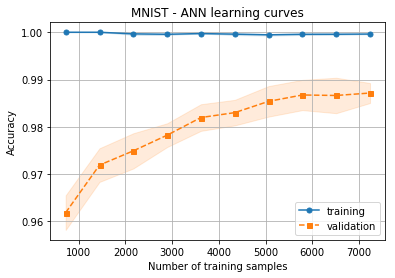

In [24]:
train_sizes, train_mean, train_std, test_mean, test_std =gen_and_plot_learning_curve(clf, X_train_scaled, y_train, random_state=1, verbose=10, ylim=None, cv=4, title='MNIST - ANN learning curves')

In [25]:
save_learning_curve(dataset, learner_type, train_sizes, train_mean, train_std, test_mean, test_std)

# Test Set Performance

In [27]:
best_clf = KerasClassifier(build_fn=build_keras_clf, verbose=0, **best_params)

best_clf.fit(X_train_scaled, y_train)
y_test_pred = best_clf.predict(X_test_scaled)
test_score = accuracy_score(y_test, y_test_pred)
print('%.4f' % test_score)

Epoch 1/100
9647/9647 [==============================] - 3s 355us/step - loss: 0.0755 - acc: 0.9239
Epoch 2/100
9647/9647 [==============================] - 3s 269us/step - loss: 0.0277 - acc: 0.9662
Epoch 3/100
9647/9647 [==============================] - 2s 232us/step - loss: 0.0223 - acc: 0.9720
Epoch 4/100
9647/9647 [==============================] - 2s 251us/step - loss: 0.0189 - acc: 0.9764
Epoch 5/100
9647/9647 [==============================] - 2s 254us/step - loss: 0.0158 - acc: 0.9811
Epoch 6/100
9647/9647 [==============================] - 2s 255us/step - loss: 0.0133 - acc: 0.9840
Epoch 7/100
9647/9647 [==============================] - 2s 247us/step - loss: 0.0111 - acc: 0.9880
Epoch 8/100
9647/9647 [==============================] - 2s 234us/step - loss: 0.0094 - acc: 0.9898
Epoch 9/100
9647/9647 [==============================] - 2s 233us/step - loss: 0.0081 - acc: 0.9923
Epoch 10/100
9647/9647 [==============================] - 2s 257us/step - loss: 0.0067 - acc: 0.9935

9647/9647 [==============================] - 2s 253us/step - loss: 3.5338e-04 - acc: 0.9997
Epoch 81/100
9647/9647 [==============================] - 2s 250us/step - loss: 3.5239e-04 - acc: 0.9997
Epoch 82/100
9647/9647 [==============================] - 2s 254us/step - loss: 3.5149e-04 - acc: 0.9997
Epoch 83/100
9647/9647 [==============================] - 2s 246us/step - loss: 3.5056e-04 - acc: 0.9997
Epoch 84/100
9647/9647 [==============================] - 3s 262us/step - loss: 3.4963e-04 - acc: 0.9997
Epoch 85/100
9647/9647 [==============================] - 2s 247us/step - loss: 3.4893e-04 - acc: 0.9997
Epoch 86/100
9647/9647 [==============================] - 2s 253us/step - loss: 3.4802e-04 - acc: 0.9997
Epoch 87/100
9647/9647 [==============================] - 2s 253us/step - loss: 3.4733e-04 - acc: 0.9997
Epoch 88/100
9647/9647 [==============================] - 2s 234us/step - loss: 3.4666e-04 - acc: 0.9997
Epoch 89/100
9647/9647 [==============================] - 2s 250us/s